In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
#Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import warnings
warnings.filterwarnings('ignore')

In [3]:
#Load the dataset
df = pd.read_csv('/content/drive/MyDrive/QUANTIUM_ANALYTICS_INTERN/QVI_data.csv')
df.head(1)

,LYLTY_CARD_NBR,DATE,STORE_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES,PACK_SIZE,BRAND,LIFESTAGE,PREMIUM_CUSTOMER
0,1000,2018-10-17,1,1,5,Natural Chip Compny SeaSalt175g,2,6.0,175,NATURAL,YOUNG SINGLES/COUPLES,Premium


The client has selected store numbers 77, 86 and 88 as trial stores and want control stores to be established
stores that are operational for the entire observation period.
We would want to match trial stores to control stores that are similar to the trial store prior to the trial period
of Feb 2019 in terms of :

•Monthly overall sales revenue

• Monthly number of customers

• Monthly number of transactions per customer

Let’s first create the metrics of interest and filter to stores that are present throughout the pre-trial period

In [4]:
df["DATE"] = pd.to_datetime(df["DATE"])
df["YEARMONTH"] = df["DATE"].dt.strftime("%Y%m").astype("int")

In [5]:
# Define the measure calculations
measure_over_time = (
    df.groupby(['STORE_NBR', 'YEARMONTH'])
    .agg(
        totSales=('TOT_SALES', 'sum'),
        nCustomers=('LYLTY_CARD_NBR', pd.Series.nunique),
        nTxnPerCust=('TXN_ID', lambda x: x.nunique() / df.loc[df['TXN_ID'].isin(x), 'LYLTY_CARD_NBR'].nunique()),
        nChipsPerTxn=('PROD_QTY', lambda x: x.sum() / x.index.nunique()),
        avgPricePerUnit=('TOT_SALES', lambda x: x.sum() / df.loc[df['TOT_SALES'].isin(x), 'PROD_QTY'].sum()))
    .reset_index()
    .sort_values(by=['STORE_NBR', 'YEARMONTH']))
# Filter to the pre-trial period and stores with full observation periods
stores_with_full_obs = measure_over_time.groupby('STORE_NBR').filter(lambda x: len(x) == 12)['STORE_NBR'].unique()

pre_trial_measures = measure_over_time[
    (measure_over_time['YEARMONTH'] < 201902) &
    (measure_over_time['STORE_NBR'].isin(stores_with_full_obs))]

Now we need to work out a way of ranking how similar each potential control store is to the trial store. We
can calculate how correlated the performance of each store is to the trial store.


In [6]:
# Create a function to calculate correlation for a measure,looping through each control store
def calculate_correlation(input_table: pd.DataFrame, metric_col: str, store_comparison: int) -> pd.DataFrame:
    """
    Calculate the correlation of a given metric across different stores.

    :param input_table: DataFrame containing the data with columns ['STORE_NBR', metric_col]
    :param metric_col: The column name for which correlation is calculated
    :param store_comparison: The store number against which other stores are compared
    :return: DataFrame with Store1, Store2, and corr_measure columns
    """
    calc_corr_table = pd.DataFrame(columns=['Store1', 'Store2', 'corr_measure'])
    store_numbers = input_table['STORE_NBR'].unique()

    for i in store_numbers:
        corr_measure = np.corrcoef(
            input_table[input_table['STORE_NBR'] == store_comparison][metric_col],
            input_table[input_table['STORE_NBR'] == i][metric_col]
        )[0, 1]

        calculated_measure = pd.DataFrame({
            'Store1': [store_comparison],
            'Store2': [i],
            'corr_measure': [corr_measure]
        })

        calc_corr_table = pd.concat([calc_corr_table, calculated_measure], ignore_index=True)

    return calc_corr_table


Apart from correlation, we can also calculate a standardised metric based on the absolute difference between the trial store’s performance and each control store’s performance.
Let’s write a function for this.

In [7]:
# Create a function to calculate a standardised magnitude distance for a measure,
# looping through each control store
def calculate_magnitude_distance(input_table: pd.DataFrame, metric_col: str, store_comparison: int) -> pd.DataFrame:
    calc_dist_table = pd.DataFrame(columns=['Store1', 'Store2', 'YEARMONTH', 'measure'])
    store_numbers = input_table['STORE_NBR'].unique()
    for i in store_numbers:
        calculated_measure = pd.DataFrame({
            'Store1': store_comparison,
            'Store2': i,
            'YEARMONTH': input_table[input_table['STORE_NBR'] == store_comparison]['YEARMONTH'].values,
            'measure': np.abs(
                input_table[input_table['STORE_NBR'] == store_comparison][metric_col].values -
                input_table[input_table['STORE_NBR'] == i][metric_col].values
            )
        })
        calc_dist_table = pd.concat([calc_dist_table, calculated_measure], ignore_index=True)
    # Standardize the magnitude distance
    min_max_dist = calc_dist_table.groupby(['Store1', 'YEARMONTH'])['measure'].agg(minDist='min', maxDist='max').reset_index()
    dist_table = pd.merge(calc_dist_table, min_max_dist, on=['Store1', 'YEARMONTH'])
    dist_table['magnitudeMeasure'] = 1 - (dist_table['measure'] - dist_table['minDist']) / (dist_table['maxDist'] - dist_table['minDist'])

    final_dist_table = dist_table.groupby(['Store1', 'Store2'])['magnitudeMeasure'].mean().reset_index()
    final_dist_table.rename(columns={'magnitudeMeasure': 'mag_measure'}, inplace=True)

    return final_dist_table

Now let’s use the functions to find the control stores! We’ll select control stores based on how similar
monthly total sales in dollar amounts and monthly number of customers are to the trial stores.

In [8]:
# Define the trial store number
trial_store = 77
# Calculate correlation for `totSales`
corr_nSales = calculate_correlation(pre_trial_measures, 'totSales', trial_store)

# Calculate correlation for `nCustomers`
corr_nCustomers = calculate_correlation(pre_trial_measures, 'nCustomers', trial_store)

# Calculate magnitude distance for `totSales`
magnitude_nSales = calculate_magnitude_distance(pre_trial_measures, 'totSales', trial_store)

# Calculate magnitude distance for `nCustomers`
magnitude_nCustomers = calculate_magnitude_distance(pre_trial_measures, 'nCustomers', trial_store)


We’ll need to combine the all the scores calculated using our function to create a composite score to rank
on.
Let’s take a simple average of the correlation and magnitude scores for each driver. Note that if we consider
it more important for the trend of the drivers to be similar, we can increase the weight of the correlation
score (a simple average gives a weight of 0.5 to the corr_weight) or if we consider the absolute size of the
drivers to be more important, we can lower the weight of the correlation score.

In [9]:
# Create a combined score composed of correlation and magnitude
corr_weight = 0.5  # Set the weight for the correlation component

# Calculate combined score for `totSales`
score_nSales = pd.merge(corr_nSales, magnitude_nSales, on=['Store1', 'Store2'])
score_nSales['scoreNSales'] = (
    score_nSales['corr_measure'] * corr_weight +
    score_nSales['mag_measure'] * (1 - corr_weight)
)

# Calculate combined score for `nCustomers`
score_nCustomers = pd.merge(corr_nCustomers, magnitude_nCustomers, on=['Store1', 'Store2'])
score_nCustomers['scoreNCust'] = (
    score_nCustomers['corr_measure'] * corr_weight +
    score_nCustomers['mag_measure'] * (1 - corr_weight)
)

# Now `score_nSales` and `score_nCustomers` contain the combined scores for each store.


In [10]:
print(score_nSales)

    Store1 Store2  corr_measure  mag_measure  scoreNSales
0       77      1      0.075218     0.953285     0.514251
1       77      2     -0.263079     0.937579     0.337250
2       77      3      0.806644     0.354315     0.580479
3       77      4     -0.263300     0.177135    -0.043082
4       77      5     -0.110652     0.553043     0.221196
..     ...    ...           ...          ...          ...
255     77    268      0.344757     0.960785     0.652771
256     77    269     -0.315730     0.452134     0.068202
257     77    270      0.315430     0.446082     0.380756
258     77    271      0.355487     0.552318     0.453902
259     77    272      0.117622     0.885088     0.501355

[260 rows x 5 columns]


Now we have a score for each of total number of sales and number of customers. Let’s combine the two
via a simple average.


In [11]:
# Combine scores across the drivers
# Merge the scores for `nSales` and `nCustomers`
score_control = pd.merge(score_nSales[['Store1', 'Store2', 'scoreNSales']],
                         score_nCustomers[['Store1', 'Store2', 'scoreNCust']],
                         on=['Store1', 'Store2'])

# Calculate the final control score
score_control['finalControlScore'] = (
    score_control['scoreNSales'] * 0.5 +
    score_control['scoreNCust'] * 0.5
)


The store with the highest score is then selected as the control store since it is most similar to the trial store.

In [12]:
# Select control stores based on the highest matching store (closest to 1 but
# not the store itself, i.e. the second ranked highest store)
trial_store = 77
# Filter and sort the DataFrame to get the second highest score for the trial store
control_store = (
    score_control[score_control['Store1'] == trial_store]
    .sort_values(by='finalControlScore', ascending=False)
    .iloc[1]  # Select the second highest score
    ['Store2']) # Get the Store2 value (control store)
print(control_store)

233


Now that we have found a control store, let’s check visually if the drivers are indeed similar in the period
before the trial.
We’ll look at total sales first.

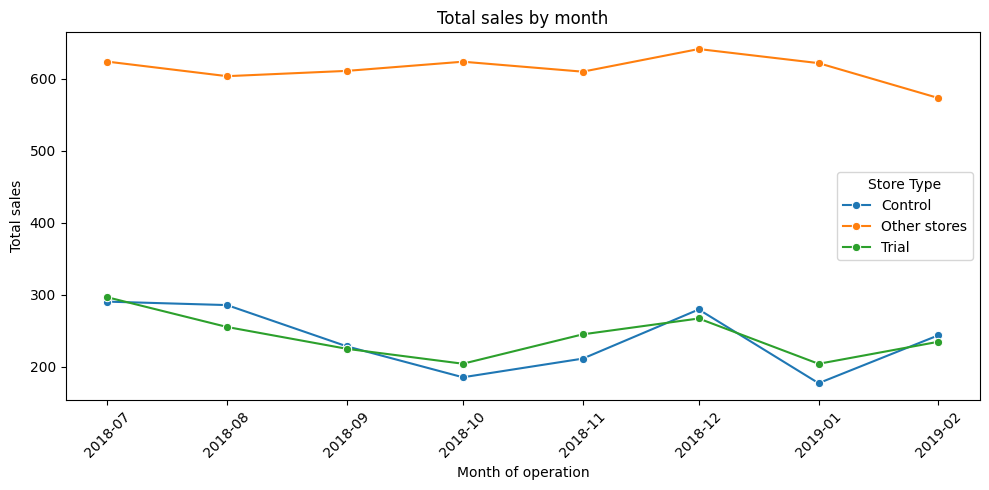

In [13]:
# Copy the DataFrame to work on total sales
measure_over_time_sales = measure_over_time.copy()

# Define the store types based on the trial store and control store
measure_over_time_sales['Store_type'] = measure_over_time_sales['STORE_NBR'].apply(
    lambda x: 'Trial' if x == trial_store else 'Control' if x == control_store else 'Other stores'
)

# Calculate the mean total sales by month and store type
past_sales = (
    measure_over_time_sales.groupby(['YEARMONTH', 'Store_type'])
    .agg({'totSales': 'mean'})
    .reset_index()
)

# Convert YEARMONTH to a datetime format for plotting
past_sales['TransactionMonth'] = pd.to_datetime(
    past_sales['YEARMONTH'].astype(str) + '01', format='%Y%m%d'
)

# Filter for months before March 2019
past_sales = past_sales[past_sales['YEARMONTH'] < 201903]

# Plot the trends using seaborn
plt.figure(figsize=(10, 5))
sns.lineplot(data=past_sales, x='TransactionMonth', y='totSales', hue='Store_type', marker="o")
plt.xlabel('Month of operation')
plt.ylabel('Total sales')
plt.title('Total sales by month')
plt.xticks(rotation=45)
plt.legend(title='Store Type')
plt.tight_layout()
plt.show()


Next, number of customers.

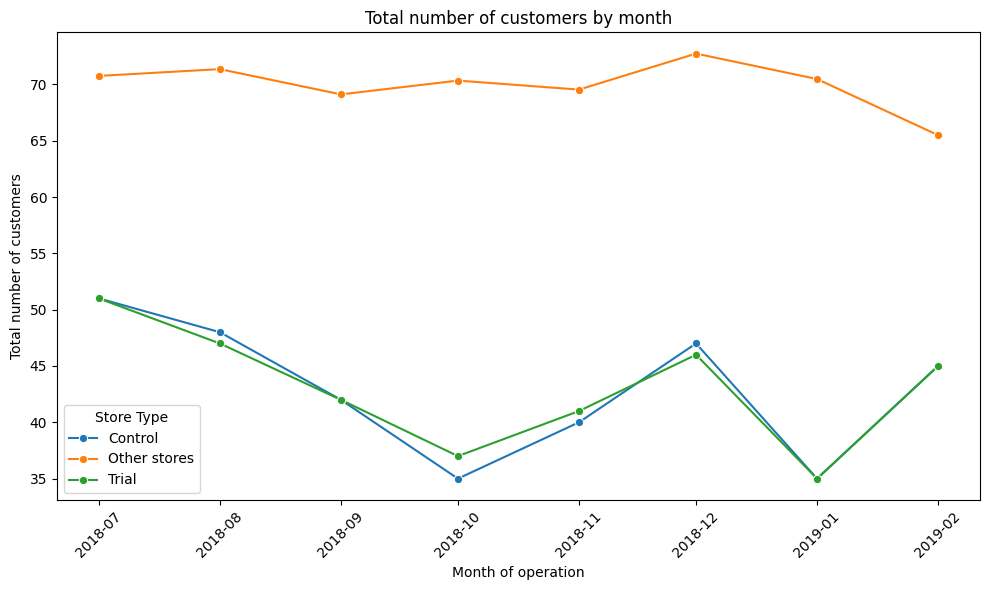

In [14]:
# Copy the DataFrame to work on number of customers
measure_over_time_customers = measure_over_time.copy()

# Define the store types based on the trial store and control store
measure_over_time_customers['Store_type'] = measure_over_time_customers['STORE_NBR'].apply(
    lambda x: 'Trial' if x == trial_store else 'Control' if x == control_store else 'Other stores'
)

# Calculate the mean number of customers by month and store type
past_customers = (
    measure_over_time_customers.groupby(['YEARMONTH', 'Store_type'])
    .agg({'nCustomers': 'mean'})
    .reset_index()
)

# Convert YEARMONTH to a datetime format for plotting
past_customers['TransactionMonth'] = pd.to_datetime(
    past_customers['YEARMONTH'].astype(str) + '01', format='%Y%m%d'
)

# Filter for months before March 2019
past_customers = past_customers[past_customers['YEARMONTH'] < 201903]

# Plot the trends using seaborn
plt.figure(figsize=(10, 6))
sns.lineplot(data=past_customers, x='TransactionMonth', y='nCustomers', hue='Store_type', marker="o")
plt.xlabel('Month of operation')
plt.ylabel('Total number of customers')
plt.title('Total number of customers by month')
plt.xticks(rotation=45)
plt.legend(title='Store Type')
plt.tight_layout()
plt.show()


##Assessment of trial
The trial period goes from the start of March 2019 to June 2019. We now want to see if there has been an
uplift in overall chip sales.
We’ll start with scaling the control store’s sales to a level similar to control for any differences between the
two stores outside of the trial period.

In [15]:
# Scale pre‐trial control sales to match pre‐trial trial store sales
# Calculate the scaling factor for control store sales
scaling_factor_for_control_sales = (
    pre_trial_measures[(pre_trial_measures['STORE_NBR'] == trial_store) & (pre_trial_measures['YEARMONTH'] < 201902)]['totSales'].sum() /
    pre_trial_measures[(pre_trial_measures['STORE_NBR'] == control_store) & (pre_trial_measures['YEARMONTH'] < 201902)]['totSales'].sum()
)

# Apply the scaling factor to the control store sales
measure_over_time_sales = measure_over_time.copy()

scaled_control_sales = measure_over_time_sales[measure_over_time_sales['STORE_NBR'] == control_store].copy()
scaled_control_sales['controlSales'] = scaled_control_sales['totSales'] * scaling_factor_for_control_sales



Now that we have comparable sales figures for the control store, we can calculate the percentage difference
between the scaled control sales and the trial store’s sales during the trial period.

In [16]:
# Merging the dataframes on 'YEARMONTH' column
percentageDiff = pd.merge(
    scaled_control_sales[['YEARMONTH', 'controlSales']],
    measure_over_time[measure_over_time['STORE_NBR'] == trial_store][['totSales', 'YEARMONTH']],
    on='YEARMONTH')
# Calculating the percentage difference
percentageDiff['percentageDiff'] = abs(percentageDiff['controlSales']
                                       - percentageDiff['totSales']) / percentageDiff['controlSales']
percentageDiff.head()


,YEARMONTH,controlSales,totSales,percentageDiff
0,201807,297.565550,296.8,0.002573
1,201808,292.652187,255.5,0.126950
2,201809,233.998916,225.2,0.037602
3,201810,190.085733,204.5,0.075830
4,201811,216.597421,245.3,0.132516


Let’s see if the difference is significant!

In [17]:
# Filter for the pre-trial period (YEARMONTH < 201902) and calculate the standard deviation
stdDev = percentageDiff[percentageDiff['YEARMONTH'] < 201902]['percentageDiff'].std()

# Set degrees of freedom
degreesOfFreedom = 7  # 8 months - 1 = 7

# Null hypothesis: there is no difference between trial and control stores
# Calculate the t-value
percentageDiff['tValue'] = (percentageDiff['percentageDiff'] - 0) / stdDev

# Convert YEARMONTH to a datetime column (TransactionMonth)
percentageDiff['TransactionMonth'] = pd.to_datetime(
    percentageDiff['YEARMONTH'].astype(str) + '01', format='%Y%m%d'
)

# Filter the results for YEARMONTH between 201902 and 201905
result = percentageDiff[(percentageDiff['YEARMONTH'] < 201905) & (percentageDiff['YEARMONTH'] > 201901)][['TransactionMonth', 'tValue']]



In [18]:
print(result)

  TransactionMonth     tValue
7       2019-02-01   1.183534
8       2019-03-01   7.339116
9       2019-04-01  12.476373


In [19]:
#Find the 95th percentile of the t distribution with the appropriate
#degrees of freedom to compare against
from scipy.stats import t
degreesOfFreedom = 7
# Find the 95th percentile of the t-distribution
t_95th_percentile = t.ppf(0.95, df=degreesOfFreedom)

# Print the result
print(t_95th_percentile)



1.894578605061305


We can observe that the t-value is much larger than the 95th percentile value of the t-distribution for March
and April - i.e. the increase in sales in the trial store in March and April is statistically greater than in the
control store.
Let’s create a more visual version of this by plotting the sales of the control store, the sales of the trial stores
and the 95th percentile value of sales of the control store.

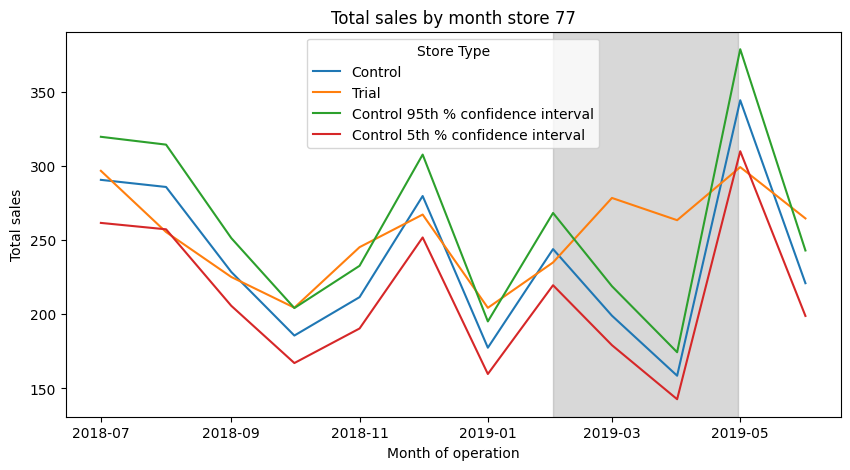

In [20]:
# Create a new column 'Store_type' to label trial, control, and other stores
measure_over_time_sales['Store_type'] = np.where(measure_over_time_sales['STORE_NBR'] == trial_store, 'Trial',
                                              np.where(measure_over_time_sales['STORE_NBR'] == control_store, 'Control', 'Other stores'))

# Calculate total sales by YEARMONTH and Store_type
past_sales = measure_over_time_sales.groupby(['YEARMONTH', 'Store_type'])['totSales'].mean().reset_index()

# Convert YEARMONTH to a TransactionMonth datetime format
past_sales['TransactionMonth'] = pd.to_datetime(past_sales['YEARMONTH'].astype(str) + '01', format='%Y%m%d')

# Filter only Trial and Control stores
past_sales = past_sales[past_sales['Store_type'].isin(['Trial', 'Control'])]

# Calculate Control store 95th percentile
past_sales_Controls95 = past_sales[past_sales['Store_type'] == 'Control'].copy()
past_sales_Controls95['totSales'] = past_sales_Controls95['totSales'] * (1 + stdDev * 2)
past_sales_Controls95['Store_type'] = 'Control 95th % confidence interval'

# Calculate Control store 5th percentile
past_sales_Controls5 = past_sales[past_sales['Store_type'] == 'Control'].copy()
past_sales_Controls5['totSales'] = past_sales_Controls5['totSales'] * (1 - stdDev * 2)
past_sales_Controls5['Store_type'] = 'Control 5th % confidence interval'

# Combine all datasets
trialAssessment = pd.concat([past_sales, past_sales_Controls95, past_sales_Controls5])

# Plotting
plt.figure(figsize=(10, 5))
sns.lineplot(data=trialAssessment, x='TransactionMonth', y='totSales', hue='Store_type')

# Highlight the period between February 2019 and April 2019
plt.axvspan(pd.to_datetime('2019-02-01'), pd.to_datetime('2019-04-30'), color='gray', alpha=0.3)

# Labels and title
plt.xlabel("Month of operation")
plt.ylabel("Total sales")
plt.title("Total sales by month store 77")
plt.legend(title='Store Type')

# Show the plot
plt.show()


The results show that the trial in store 77 is significantly different to its control store in the trial period as
the trial store performance lies outside the 5% to 95% confidence interval of the control store in two of the
three trial months.
Let’s have a look at assessing this for number of customers as well

In [21]:
# Calculate the scaling factor for control customers
scalingFactorForControlCust = (
    pre_trial_measures[(pre_trial_measures['STORE_NBR'] == trial_store) & (pre_trial_measures['YEARMONTH'] < 201902)]['nCustomers'].sum() /
    pre_trial_measures[(pre_trial_measures['STORE_NBR'] == control_store) & (pre_trial_measures['YEARMONTH'] < 201902)]['nCustomers'].sum()
)

# Apply the scaling factor to control store customers
scaled_control_customers = measure_over_time_customers[measure_over_time_customers['STORE_NBR'] == control_store].copy()
scaled_control_customers['controlCustomers'] = scaled_control_customers['nCustomers'] * scalingFactorForControlCust

# Add Store_type column
scaled_control_customers['Store_type'] = scaled_control_customers['STORE_NBR'].apply(
    lambda x: 'Trial' if x == trial_store else ('Control' if x == control_store else 'Other stores')
)

# Merge scaled control customers with trial store customers by YEARMONTH
percentageDiff = pd.merge(
    scaled_control_customers[['YEARMONTH', 'controlCustomers']],
    measure_over_time_customers[measure_over_time_customers['STORE_NBR'] == trial_store][['nCustomers', 'YEARMONTH']],
    on='YEARMONTH'
)

# Calculate the percentage difference
percentageDiff['percentageDiff'] = abs(percentageDiff['controlCustomers'] - percentageDiff['nCustomers']) / percentageDiff['controlCustomers']


Let’s again see if the difference is significant visually!

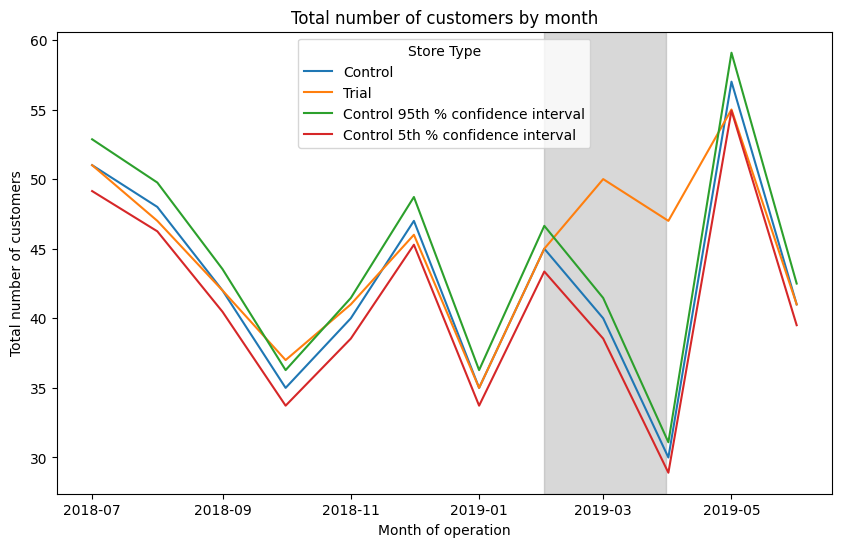

In [22]:
# Calculate the standard deviation of the percentage difference during the pre-trial period
stdDev = percentageDiff[percentageDiff['YEARMONTH'] < 201902]['percentageDiff'].std()

# Set degrees of freedom
degreesOfFreedom = 7  # 8 months - 1 = 7

# Calculate the mean number of customers by YEARMONTH and Store_type
past_customers = measure_over_time_customers.groupby(['YEARMONTH', 'Store_type'])['nCustomers'].mean().reset_index()
past_customers.rename(columns={'nCustomers': 'nCusts'}, inplace=True)

# Filter for only Trial and Control stores
past_customers = past_customers[past_customers['Store_type'].isin(['Trial', 'Control'])]

# Calculate Control store 95th percentile
past_customers_Controls95 = past_customers[past_customers['Store_type'] == 'Control'].copy()
past_customers_Controls95['nCusts'] = past_customers_Controls95['nCusts'] * (1 + stdDev * 2)
past_customers_Controls95['Store_type'] = 'Control 95th % confidence interval'

# Calculate Control store 5th percentile
pastCustomers_Controls5 = past_customers[past_customers['Store_type'] == 'Control'].copy()
pastCustomers_Controls5['nCusts'] = pastCustomers_Controls5['nCusts'] * (1 - stdDev * 2)
pastCustomers_Controls5['Store_type'] = 'Control 5th % confidence interval'

# Combine all datasets
trialAssessment = pd.concat([past_customers, past_customers_Controls95, pastCustomers_Controls5])

# Convert YEARMONTH to a TransactionMonth datetime format
trialAssessment['TransactionMonth'] = pd.to_datetime(trialAssessment['YEARMONTH'].astype(str) + '01', format='%Y%m%d')

# Plotting
plt.figure(figsize=(10, 6))
sns.lineplot(data=trialAssessment, x='TransactionMonth', y='nCusts', hue='Store_type')

# Highlight the period between February 2019 and April 2019
plt.axvspan(pd.to_datetime('2019-02-01'), pd.to_datetime('2019-03-31'), color='gray', alpha=0.3)

# Labels and title
plt.xlabel("Month of operation")
plt.ylabel("Total number of customers")
plt.title("Total number of customers by month")
plt.legend(title='Store Type')
plt.show()


Let’s repeat finding the control store and assessing the impact of the trial for each of the other two trial
stores.


**Trial store 86**

In [23]:
#Calculate correlation for sales and customers
trial_store2 = 86

corr_nSales = calculate_correlation(pre_trial_measures, 'totSales', trial_store2)
corr_nCustomers = calculate_correlation(pre_trial_measures, 'nCustomers', trial_store2)

#Calculate magnitude for sales and customers
magnitude_nSales = calculate_magnitude_distance(pre_trial_measures, 'totSales', trial_store2)
magnitude_nCustomers = calculate_magnitude_distance(pre_trial_measures, 'nCustomers', trial_store2)

#Create combined score using correlation and magnitude
corr_weight = 0.5

score_nSales = pd.merge(corr_nSales, magnitude_nSales, on=['Store1', 'Store2'])
score_nSales['scoreNSales'] = (
    score_nSales['corr_measure'] * corr_weight +
    score_nSales['mag_measure'] * (1 - corr_weight)
    )
score_nCustomers = pd.merge(corr_nCustomers, magnitude_nCustomers, on=['Store1', 'Store2'])
score_nCustomers['scoreNCust'] = (
    score_nCustomers['corr_measure'] * corr_weight +
    score_nCustomers['mag_measure'] * (1 - corr_weight))

#Combine scores for both sales and customers
score_Control = pd.merge(score_nSales, score_nCustomers, on=['Store1', 'Store2'])
score_Control['finalControlScore'] = (
    score_Control['scoreNSales'] * 0.5 + score_Control['scoreNCust'] * 0.5
)
#Select the control store (the second-highest matching store, excluding the store itself)
control_store = (
    score_Control[score_Control['Store1'] == trial_store2]
    .sort_values(by='finalControlScore', ascending=False)
    .iloc[1]['Store2']
)

print("Selected Control Store:", control_store)


Selected Control Store: 155


Store 155 will be a control store for trial store 86. Again, let’s check visually if the drivers are
indeed similar in the period before the trial.

We’ll look at total sales first.

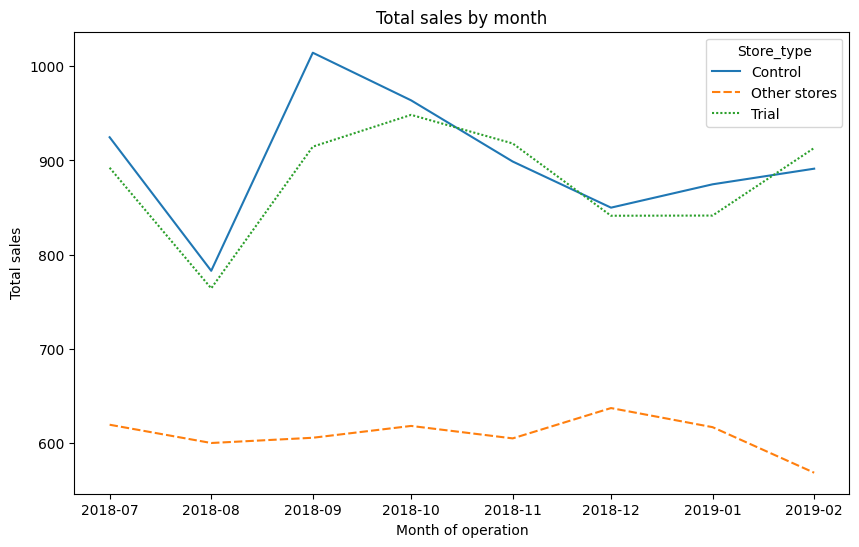

In [24]:
#Assign the store type (Trial, Control, Other stores)
measure_over_time_sales['Store_type'] = np.where(
    measure_over_time_sales['STORE_NBR'] == trial_store2, 'Trial',
    np.where(measure_over_time_sales['STORE_NBR'] == control_store, 'Control', 'Other stores'))
#Calculate the mean total sales by YEARMONTH and Store_type
past_sales = (
    measure_over_time_sales.groupby(['YEARMONTH', 'Store_type'], as_index=False)
    .agg({'totSales': 'mean'}))
#Create TransactionMonth as a datetime column from YEARMONTH
past_sales['TransactionMonth'] = pd.to_datetime(
    past_sales['YEARMONTH'].astype(str).str[:4] + '-' + past_sales['YEARMONTH'].astype(str).str[4:] + '-01'
)

#Filter for months before March 2019 (YEARMONTH < 201903)
past_sales = past_sales[past_sales['YEARMONTH'] < 201903]

#Plot the data
plt.figure(figsize=(10, 6))
sns.lineplot(data=past_sales, x='TransactionMonth', y='totSales', hue='Store_type', style='Store_type')
plt.xlabel('Month of operation')
plt.ylabel('Total sales')
plt.title('Total sales by month')
plt.show()


Great, sales are trending in a similar way.

Next, number of customers.


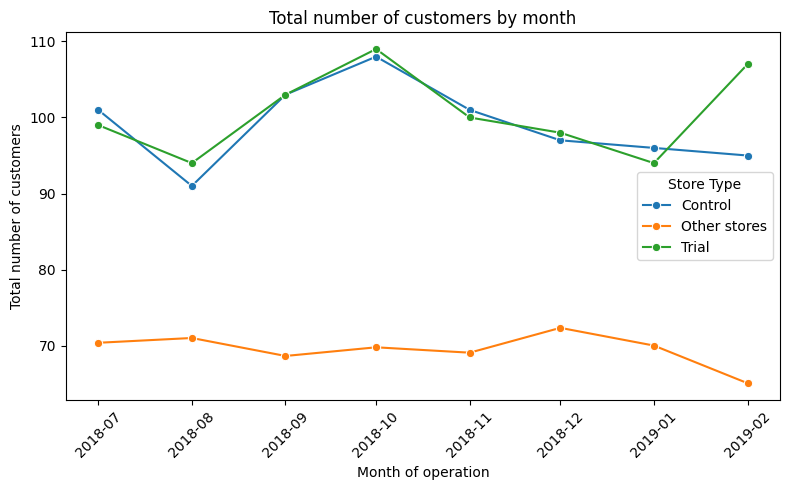

In [25]:
# Define the store types based on the trial store and control store
measure_over_time_customers['Store_type'] = measure_over_time_customers['STORE_NBR'].apply(
    lambda x: 'Trial' if x == trial_store2 else 'Control' if x == control_store else 'Other stores'
)
# Calculate the mean number of customers by month and store type
past_customers = (
    measure_over_time_customers.groupby(['YEARMONTH', 'Store_type'])
    .agg({'nCustomers': 'mean'})
    .reset_index()
)
# Convert YEARMONTH to a datetime format for plotting
past_customers['TransactionMonth'] = pd.to_datetime(
    past_customers['YEARMONTH'].astype(str) + '01', format='%Y%m%d'
)
# Filter for months before March 2019
past_customers = past_customers[past_customers['YEARMONTH'] < 201903]

# Plot the trends using seaborn
plt.figure(figsize=(8, 5))
sns.lineplot(data=past_customers, x='TransactionMonth', y='nCustomers', hue='Store_type', marker="o")
plt.xlabel('Month of operation')
plt.ylabel('Total number of customers')
plt.title('Total number of customers by month')
plt.xticks(rotation=45)
plt.legend(title='Store Type')
plt.tight_layout()
plt.show()

Good, the trend in number of customers is also similar.

Let’s now assess the impact of the trial on sales.


In [27]:
from datetime import datetime


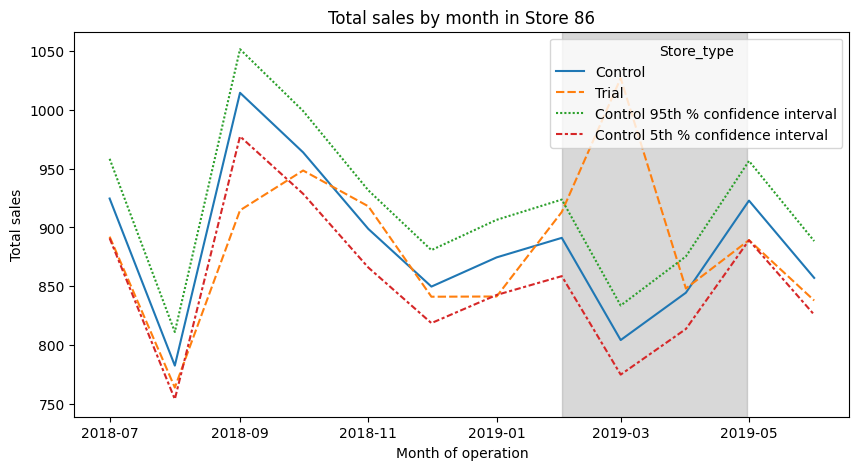

In [33]:
trial_store2 = 86
# Create a new column 'Store_type' to label trial, control, and other stores
measure_over_time_sales['Store_type'] = np.where(measure_over_time_sales['STORE_NBR'] == trial_store2, 'Trial',
                                                 np.where(measure_over_time_sales['STORE_NBR'] == control_store, 'Control', 'Other stores'))

# Calculate total sales by YEARMONTH and Store_type
past_sales = measure_over_time_sales.groupby(['YEARMONTH', 'Store_type'])['totSales'].mean().reset_index()

# Convert YEARMONTH to a TransactionMonth datetime format
past_sales['TransactionMonth'] = pd.to_datetime(past_sales['YEARMONTH'].astype(str) + '01', format='%Y%m%d')

# Filter only Trial and Control stores
past_sales = past_sales[past_sales['Store_type'].isin(['Trial', 'Control'])]

# Calculate Control store 95th percentile
past_sales_Controls95 = past_sales[past_sales['Store_type'] == 'Control'].copy()
past_sales_Controls95['totSales'] = past_sales_Controls95['totSales'] * (1 + stdDev * 2)
past_sales_Controls95['Store_type'] = 'Control 95th % confidence interval'

# Calculate Control store 5th percentile
past_sales_Controls5 = past_sales[past_sales['Store_type'] == 'Control'].copy()
past_sales_Controls5['totSales'] = past_sales_Controls5['totSales'] * (1 - stdDev * 2)
past_sales_Controls5['Store_type'] = 'Control 5th % confidence interval'

# Combine all datasets
trialAssessment = pd.concat([past_sales, past_sales_Controls95, past_sales_Controls5])

# Plotting
plt.figure(figsize=(10, 5))
sns.lineplot(data=trialAssessment, x='TransactionMonth', y='totSales', hue='Store_type',
             style='Store_type')
plt.axvspan(pd.to_datetime('2019-02-01'), pd.to_datetime('2019-04-30'), color='gray', alpha=0.3)
plt.xlabel("Month of operation")
plt.ylabel("Total sales")
plt.title("Total sales by month in Store 86")
plt.show()

# Apply scaling factor to control sales
scaling_factor_for_control_sales = pre_trial_measures[(pre_trial_measures['STORE_NBR'] == trial_store2) &
                                                (pre_trial_measures['YEARMONTH'] < 201902)]['totSales'].sum() / \
                               pre_trial_measures[(pre_trial_measures['STORE_NBR'] == control_store) &
                                                (pre_trial_measures['YEARMONTH'] < 201902)]['totSales'].sum()

measure_over_time_sales['controlSales'] = np.where(measure_over_time_sales['STORE_NBR'] == control_store,
                                                   measure_over_time_sales['totSales'] * scaling_factor_for_control_sales, np.nan)

# Calculate percentage difference between scaled control sales and trial sales
scaledControlSales = measure_over_time_sales[measure_over_time_sales['STORE_NBR'] == control_store][['YEARMONTH', 'controlSales']]
trialSales = measure_over_time_sales[measure_over_time_sales['STORE_NBR'] == trial_store2][['YEARMONTH', 'totSales']]

# Merge and calculate percentage difference
percentageDiff = pd.merge(scaledControlSales, trialSales, on='YEARMONTH')
percentageDiff['percentageDiff'] = abs(percentageDiff['controlSales'] - percentageDiff['totSales']) / percentageDiff['controlSales']

# Calculate the standard deviation of percentage difference in the pre-trial period
stdDev = percentageDiff[percentageDiff['YEARMONTH'] < 201902]['percentageDiff'].std()


The results show that the trial in store 86 is not significantly different to its control store in the trial period
as the trial store performance lies inside the 5% to 95% confidence interval of the control store in two of the
three trial months.

Let’s have a look at assessing this for number of customers as well.

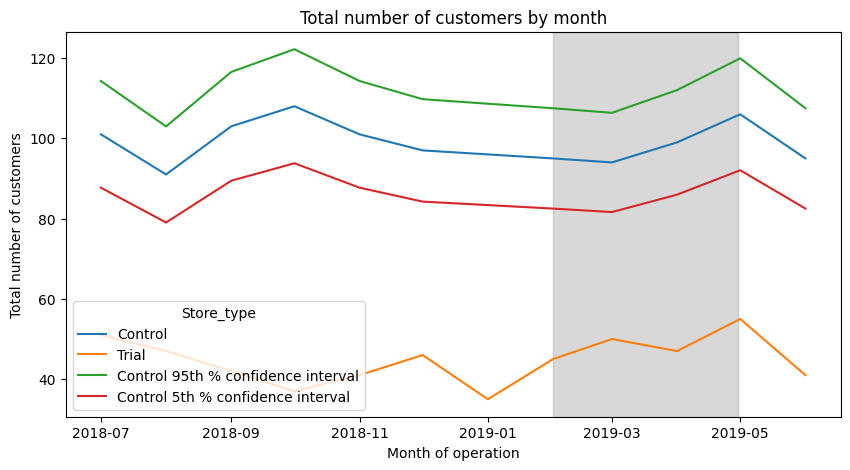

In [36]:
# Scale pre-trial control customers to match pre-trial trial store customers
scaling_factor_for_control_cust = pre_trial_measures[(pre_trial_measures['STORE_NBR'] == trial_store) &
                                               (pre_trial_measures['YEARMONTH'] < 201902)]['nCustomers'].sum() / \
                              pre_trial_measures[(pre_trial_measures['STORE_NBR'] == control_store) &
                                               (pre_trial_measures['YEARMONTH'] < 201902)]['nCustomers'].sum()

# Apply the scaling factor
measure_over_time_customers = measure_over_time.copy()
measure_over_time_customers['controlCustomers'] = np.where(measure_over_time_customers['STORE_NBR'] == control_store,
                                                    measure_over_time_customers['nCustomers'] * scaling_factor_for_control_cust, np.nan)

measure_over_time_customers['Store_type'] = np.where(measure_over_time_customers['STORE_NBR'] == trial_store, 'Trial',
                                              np.where(measure_over_time_customers['STORE_NBR'] == control_store, 'Control', 'Other stores'))

# Calculate percentage difference between scaled control customers and trial customers
scaledControlCustomers = measure_over_time_customers[measure_over_time_customers['STORE_NBR'] == control_store][['YEARMONTH', 'controlCustomers']]
trialCustomers = measure_over_time_customers[measure_over_time_customers['STORE_NBR'] == trial_store][['YEARMONTH', 'nCustomers']]

percentageDiff = pd.merge(scaledControlCustomers, trialCustomers, on='YEARMONTH')
percentageDiff['percentageDiff'] = abs(percentageDiff['controlCustomers'] - percentageDiff['nCustomers']) / percentageDiff['controlCustomers']

# Calculate the standard deviation based on the pre-trial percentage difference
stdDev = percentageDiff[percentageDiff['YEARMONTH'] < 201902]['percentageDiff'].std()
degreesOfFreedom = 7

# Calculate mean number of customers by YEARMONTH and Store_type
pastCustomers = measure_over_time_customers.groupby(['YEARMONTH', 'Store_type'])['nCustomers'].mean().reset_index()

# Filter for only Trial and Control stores
pastCustomers = pastCustomers[pastCustomers['Store_type'].isin(['Trial', 'Control'])]

# Calculate Control store 95th percentile
pastCustomers_Controls95 = pastCustomers[pastCustomers['Store_type'] == 'Control'].copy()
pastCustomers_Controls95['nCustomers'] = pastCustomers_Controls95['nCustomers'] * (1 + stdDev * 2)
pastCustomers_Controls95['Store_type'] = 'Control 95th % confidence interval'

# Calculate Control store 5th percentile
pastCustomers_Controls5 = pastCustomers[pastCustomers['Store_type'] == 'Control'].copy()
pastCustomers_Controls5['nCustomers'] = pastCustomers_Controls5['nCustomers'] * (1 - stdDev * 2)
pastCustomers_Controls5['Store_type'] = 'Control 5th % confidence interval'

# Combine the datasets
trialAssessment = pd.concat([pastCustomers, pastCustomers_Controls95, pastCustomers_Controls5])

# Convert YEARMONTH to TransactionMonth datetime format
trialAssessment['TransactionMonth'] = pd.to_datetime(trialAssessment['YEARMONTH'].astype(str) + '01', format='%Y%m%d')

# Plotting
plt.figure(figsize=(10, 5))
sns.lineplot(data=trialAssessment, x='TransactionMonth', y='nCustomers', hue='Store_type')

# Highlight the pre-trial period (between February 2019 and April 2019)
plt.axvspan(pd.to_datetime('2019-02-01'), pd.to_datetime('2019-04-30'), color='gray', alpha=0.3)

# Labels and title
plt.xlabel("Month of operation")
plt.ylabel("Total number of customers")
plt.title("Total number of customers by month")

# Show the plot
plt.show()


It looks like the number of customers is significantly higher in all of the three months.

This seems to
suggest that the trial had a significant impact on increasing the number of customers in trial store 86 but
as we saw, sales were not significantly higher.

We should check with the Category Manager if there were
special deals in the trial store that were may have resulted in lower prices, impacting the results.


**Trial store 88**

In [40]:
#Calculate correlation for sales and customers
trial_store3 = 88
corr_nSales = calculate_correlation(pre_trial_measures, 'totSales', trial_store3)
corr_nCustomers = calculate_correlation(pre_trial_measures, 'nCustomers', trial_store3)
#Calculate magnitude for sales and customers
magnitude_nSales = calculate_magnitude_distance(pre_trial_measures, 'totSales', trial_store3)
magnitude_nCustomers = calculate_magnitude_distance(pre_trial_measures, 'nCustomers', trial_store3)
#Create combined score using correlation and magnitude
corr_weight = 0.5
score_nSales = pd.merge(corr_nSales, magnitude_nSales, on=['Store1', 'Store2'])
score_nSales['scoreNSales'] = (
    score_nSales['corr_measure'] * corr_weight +
    score_nSales['mag_measure'] * (1 - corr_weight))
score_nCustomers = pd.merge(corr_nCustomers, magnitude_nCustomers, on=['Store1', 'Store2'])
score_nCustomers['scoreNCust'] = (
    score_nCustomers['corr_measure'] * corr_weight +
    score_nCustomers['mag_measure'] * (1 - corr_weight))
#Combine scores for both sales and customers
score_Control = pd.merge(score_nSales, score_nCustomers, on=['Store1', 'Store2'])
score_Control['finalControlScore'] = (
    score_Control['scoreNSales'] * 0.5 + score_Control['scoreNCust'] * 0.5)
#Select the control store (the second-highest matching store, excluding the store itself)
control_store = (
    score_Control[score_Control['Store1'] == trial_store3]
    .sort_values(by='finalControlScore', ascending=False)
    .iloc[1]['Store2'])
print("Selected Control Store:", control_store)

Selected Control Store: 237


We’ve now found store 237 to be a suitable control store for trial store 88.
Again, let’s check visually if the drivers are indeed similar in the period before the trial.
We’ll look at total sales first.

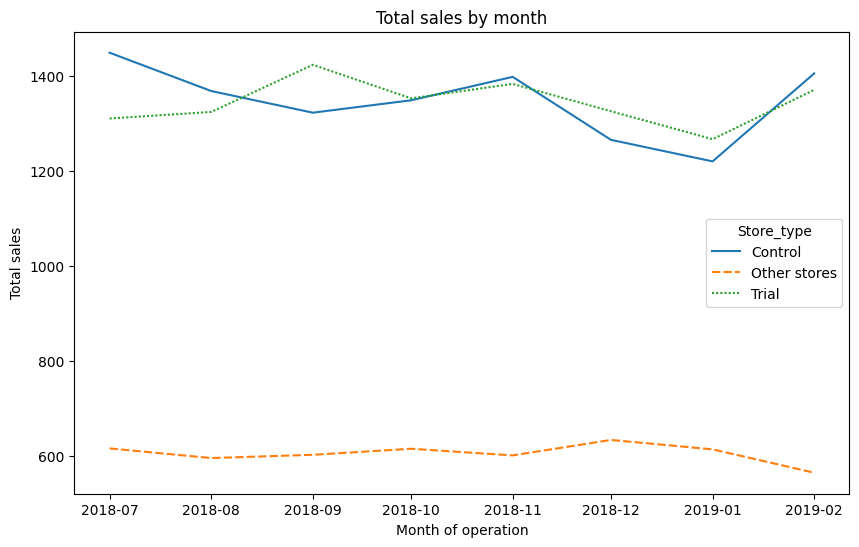

In [41]:
#Assign the store type (Trial, Control, Other stores)
measure_over_time_sales['Store_type'] = np.where(
    measure_over_time_sales['STORE_NBR'] == trial_store3, 'Trial',
    np.where(measure_over_time_sales['STORE_NBR'] == control_store, 'Control', 'Other stores'))
#Calculate the mean total sales by YEARMONTH and Store_type
past_sales = (
    measure_over_time_sales.groupby(['YEARMONTH', 'Store_type'], as_index=False)
    .agg({'totSales': 'mean'}))
#Create TransactionMonth as a datetime column from YEARMONTH
past_sales['TransactionMonth'] = pd.to_datetime(
    past_sales['YEARMONTH'].astype(str).str[:4] + '-' + past_sales['YEARMONTH'].astype(str).str[4:] + '-01'
)

#Filter for months before March 2019 (YEARMONTH < 201903)
past_sales = past_sales[past_sales['YEARMONTH'] < 201903]

#Plot the data
plt.figure(figsize=(10, 6))
sns.lineplot(data=past_sales, x='TransactionMonth', y='totSales', hue='Store_type', style='Store_type')

#Set labels and title
plt.xlabel('Month of operation')
plt.ylabel('Total sales')
plt.title('Total sales by month')

# Display the plot
plt.show()

Great, the trial and control stores have similar total sales.
Next, number of customers.


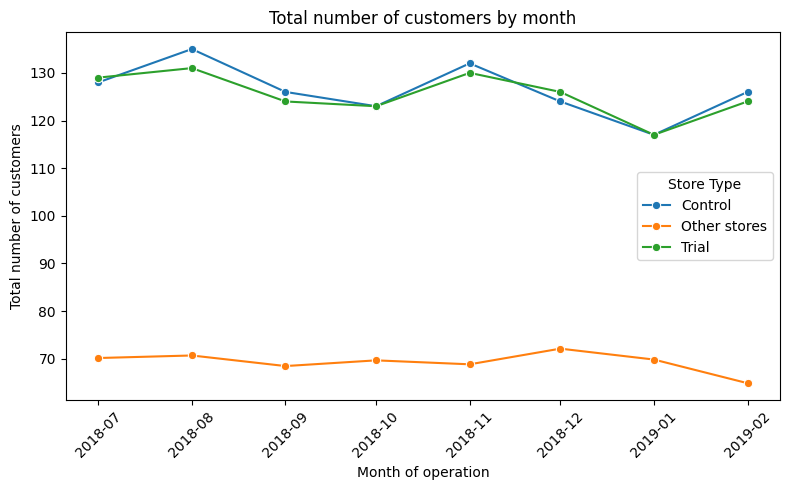

In [42]:
# Define the store types based on the trial store and control store
measure_over_time_customers['Store_type'] = measure_over_time_customers['STORE_NBR'].apply(
    lambda x: 'Trial' if x == trial_store3 else 'Control' if x == control_store else 'Other stores'
)

# Calculate the mean number of customers by month and store type
past_customers = (
    measure_over_time_customers.groupby(['YEARMONTH', 'Store_type'])
    .agg({'nCustomers': 'mean'})
    .reset_index()
)

# Convert YEARMONTH to a datetime format for plotting
past_customers['TransactionMonth'] = pd.to_datetime(
    past_customers['YEARMONTH'].astype(str) + '01', format='%Y%m%d'
)

# Filter for months before March 2019
past_customers = past_customers[past_customers['YEARMONTH'] < 201903]

# Plot the trends using seaborn
plt.figure(figsize=(8, 5))
sns.lineplot(data=past_customers, x='TransactionMonth', y='nCustomers', hue='Store_type', marker="o")
plt.xlabel('Month of operation')
plt.ylabel('Total number of customers')
plt.title('Total number of customers by month')
plt.xticks(rotation=45)
plt.legend(title='Store Type')
plt.tight_layout()
plt.show()

Total number of customers of the control and trial stores are also similar.

Let’s now assess the impact of the trial on sales.

In [ ]:
# Create a new column 'Store_type' to label trial, control, and other stores
trial_store = 88
measure_over_time_sales['Store_type'] = np.where(measure_over_time_sales['STORE_NBR'] == trial_store, 'Trial',
                                              np.where(measure_over_time_sales['STORE_NBR'] == control_store, 'Control', 'Other stores'))

# Calculate total sales by YEARMONTH and Store_type
past_sales = measure_over_time_sales.groupby(['YEARMONTH', 'Store_type'])['totSales'].mean().reset_index()

# Convert YEARMONTH to a TransactionMonth datetime format
past_sales['TransactionMonth'] = pd.to_datetime(past_sales['YEARMONTH'].astype(str) + '01', format='%Y%m%d')

# Filter only Trial and Control stores
past_sales = past_sales[past_sales['Store_type'].isin(['Trial', 'Control'])]

# Calculate Control store 95th percentile
past_sales_Controls95 = past_sales[past_sales['Store_type'] == 'Control'].copy()
past_sales_Controls95['totSales'] = past_sales_Controls95['totSales'] * (1 + stdDev * 2)
past_sales_Controls95['Store_type'] = 'Control 95th % confidence interval'

# Calculate Control store 5th percentile
past_sales_Controls5 = past_sales[past_sales['Store_type'] == 'Control'].copy()
past_sales_Controls5['totSales'] = past_sales_Controls5['totSales'] * (1 - stdDev * 2)
past_sales_Controls5['Store_type'] = 'Control 5th % confidence interval'

# Combine all datasets
trialAssessment = pd.concat([past_sales, past_sales_Controls95, past_sales_Controls5])

# Plotting
plt.figure(figsize=(10, 5))
sns.lineplot(data=trialAssessment, x='TransactionMonth', y='totSales', hue='Store_type')

# Highlight the period between February 2019 and April 2019
plt.axvspan(pd.to_datetime('2019-02-01'), pd.to_datetime('2019-04-30'), color='gray', alpha=0.3)
plt.xlabel("Month of operation")
plt.ylabel("Total sales")
plt.title("Total sales by month Store 88")
plt.legend(title='Store Type')
plt.show()

The results show that the trial in store 88 is significantly different to its control store in the trial period as the
trial store performance lies outside of the 5% to 95% confidence interval of the control store in two of the
three trial months.

Let’s have a look at assessing this for number of customers as well.

In [ ]:
#Scale pre-trial control customers to match pre-trial trial store customers
scalingFactorForControlCust = (
    pre_trial_measures[(pre_trial_measures['STORE_NBR'] == trial_store) & (pre_trial_measures['YEARMONTH'] < 201902)]['nCustomers'].sum() /
    pre_trial_measures[(pre_trial_measures['STORE_NBR'] == control_store) & (pre_trial_measures['YEARMONTH'] < 201902)]['nCustomers'].sum()
)

#Apply the scaling factor to control store customers
measure_over_time_customers = measure_over_time.copy()
scaled_control_customers = measure_over_time_customers[measure_over_time_customers['STORE_NBR'] == control_store].copy()
scaled_control_customers['controlCustomers'] = scaled_control_customers['nCustomers'] * scalingFactorForControlCust

#Calculate the percentage difference between scaled control customers and trial customers
percentage_diff = pd.merge(
    scaled_control_customers[['YEARMONTH', 'controlCustomers']],
    measure_over_time[measure_over_time['STORE_NBR'] == trial_store][['nCustomers', 'YEARMONTH']],
    on='YEARMONTH'
)

percentage_diff['percentageDiff'] = np.abs(percentage_diff['controlCustomers'] - percentage_diff['nCustomers']) / percentage_diff['controlCustomers']

#Calculate the standard deviation of percentage difference in pre-trial period
stdDev = percentage_diff[percentage_diff['YEARMONTH'] < 201902]['percentageDiff'].std()
degrees_of_freedom = 7  # 8 months - 1 = 7

#Calculate the mean number of customers by YEARMONTH and Store_type
measure_over_time_customers['Store_type'] = np.where(
    measure_over_time_customers['STORE_NBR'] == trial_store, 'Trial',
    np.where(measure_over_time_customers['STORE_NBR'] == control_store, 'Control', 'Other stores')
)

past_customers = (
    measure_over_time_customers.groupby(['YEARMONTH', 'Store_type'], as_index=False)
    .agg({'nCustomers': 'mean'})
)
past_customers.rename(columns={'nCustomers': 'nCusts'}, inplace=True)

#Calculate Control store 95th percentile
past_customers_Controls95 = past_customers[past_customers['Store_type'] == 'Control'].copy()
past_customers_Controls95['nCusts'] = past_customers_Controls95['nCusts'] * (1 + stdDev * 2)
past_customers_Controls95['Store_type'] = 'Control 95th % confidence interval'

#Calculate Control store 5th percentile
past_customers_Controls5 = past_customers[past_customers['Store_type'] == 'Control'].copy()
past_customers_Controls5['nCusts'] = past_customers_Controls5['nCusts'] * (1 - stdDev * 2)
past_customers_Controls5['Store_type'] = 'Control 5th % confidence interval'

#Combine all past_customers data
trial_assessment = pd.concat([past_customers, past_customers_Controls95, past_customers_Controls5], ignore_index=True)
#Convert YEARMONTH to a TransactionMonth datetime format
trial_assessment['TransactionMonth'] = pd.to_datetime(trial_assessment['YEARMONTH'].astype(str) + '01', format='%Y%m%d')
#Plotting the result
plt.figure(figsize=(10, 6))
# Highlight the period between February 2019 and April 2019
plt.axvspan(pd.to_datetime('2019-02-01'), pd.to_datetime('2019-03-31'), color='gray', alpha=0.3)
# Plot the lines for total number of customers across store types
sns.lineplot(data=trial_assessment, x='TransactionMonth', y='nCusts', hue='Store_type')
plt.xlabel('Month of operation')
plt.ylabel('Total number of customers')
plt.title('Total number of customers by month')
plt.legend(title='Store Type')
plt.show()

Total number of customers in the trial period for the trial store is significantly higher than the control store
for two out of three months, which indicates a positive trial effect.

**Conclusion**

We’ve found control stores 233, 155, 237 for trial stores 77, 86 and 88 respectively.
The results for trial stores 77 and 88 during the trial period show a significant difference in at least two of the
three trial months but this is not the case for trial store 86. We can check with the client if the implementation
of the trial was different in trial store 86 but overall, the trial shows a significant increase in sales.